# Evaluate the psychosis dataset with neuropsych measures

In [1]:
from __future__ import division

from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import GaussianNB
from utils.prog import log_progress as lp
from sklearn.svm import SVC, LinearSVC
import statsmodels.formula.api as smf
from numpy import transpose as T
from IPython.display import HTML
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.api as sm
from utils import neuropsych
import scipy.stats as stats
import matplotlib as mpl
import sklearn.cluster
import seaborn as sns
import datetime as dt
import pandas as pd
import numpy as np
import palettable
import warnings
import scipy
import time
import json
import sys
import os

%matplotlib inline
%load_ext rpy2.ipython

#cols = palettable.colorbrewer.qualitative.Dark2_8.hex_colors
cols = palettable.tableau.ColorBlind_10.hex_colors
cols += palettable.tableau.PurpleGray_6.hex_colors
cols += palettable.tableau.Tableau_10.hex_colors

#warnings.filterwarnings("ignore")
CONDIR = os.environ.get("CONDIR")

## Read in data

The data has been cleaned/preprocessed in another notebook.  These data now mostly consist of composite scores based on questionnaires.  For more details, see the other notebook.

In [2]:
# cleaned data
RC_clean = pd.read_csv(os.path.join(os.environ.get("TABLEDIR"),
                                    "neuropsych_clean.csv"),index_col=0)
RC_clean = RC_clean.fillna(0)

subsetfile = os.path.join(os.environ.get("TABLEDIR"),
                          "neuropsych_clean_dict.json")
with open(subsetfile) as json_data:
    subsets = json.load(json_data)

print("There are %i variables in the cleaned dataset."%(
        len(RC_clean.columns)-1)) #x-1 because patient is in there...

There are 53 variables in the cleaned dataset.


In [3]:
# raw data
table = "FULLTABLE"

RC, labeltable = neuropsych.get_tables(table)
# this is a subset of the dataset with all categorical variables
labeltable, RC_table = neuropsych.subset_tables(table=table, 
                                                RC=RC, 
                                                labeltable=labeltable)
# this removes all variables that are empty
labeltable, FA_table = neuropsych.clean_tables(labeltable,
                                               RC_table,cor_lim=1)

    ...getting redcap instruments...
There are 485 variables considered.


## Baseline prediction accuracy based on neuropsych variables

Here we look at the baseline performance of two machine learning algorithms: Naive Bayes and SVM.  With a sample size of 140, the learning curve reaches a platform at almost 100% prediction accuracy.

In [4]:
def plot_learning_curve(estimator,title,X,y,ylim,cv=None,n_jobs=3,train_sizes = np.linspace(0.1,1.0,10)):
    plt.figure()
    plt.title(title)
    plt.ylim(ylim)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=4, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.xlabel("Training sample size")
    plt.ylabel("classification accuracy")
    plt.legend()



/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


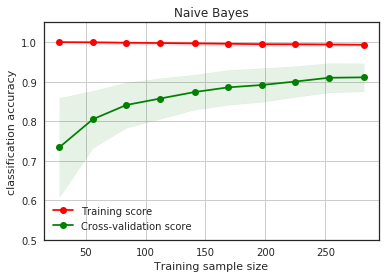

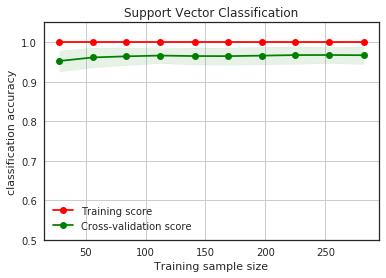

In [5]:
Y_init = RC.is_this_subject_a_patient
X_init = FA_table

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=80, test_size=0.2, random_state=100)
sns.set_style("white")

estimator = GaussianNB()
plot_learning_curve(estimator,"Naive Bayes",X_init,Y_init,ylim=[0.5,1.05],cv=cv)

estimator = LinearSVC()
plot_learning_curve(estimator,"Support Vector Classification",
                    X_init,Y_init,ylim=[0.5,1.05],cv=cv)


## Prepare cleaned data for factor analysis

In [6]:
st = "<h3>Neuropsych measures used for factor analysis.</h3><br>"
for k,v in subsets.iteritems():
    if k=='patient': k='patient (Y)'
    st+="<b>%s</b>"%k
    st+="<br>%s</br>"%", ".join(v)

HTML(st)

## Separate X and Y

In [7]:
Xvar = [
 'legal_issues',
 'YMRS - young mania',
 'bprse - psychiatric rating',
#  'THQ - trauma history',
 'CTQ - child trauma',
 'scid_screener - structured interview',
 'HAMD - depression',
 'WASI - intelligence',
 'Family_History_Assessment',
 'scid_face_axis - structured interview',
 'LDPS - lifetime dimensions of psychosis']

all_vars = []; all_labels=[]
for k,v in subsets.iteritems():
    if k in Xvar:
        all_vars += v
        all_labels += [k]*len(v)

X = np.array(RC_clean[all_vars])
Y = np.array(RC_clean['patient'])
Y = np.array([1 if x==888 else 0 for x in Y])
ID = RC_clean['UID']

# How is prediction affected by this reduction?

Nice ! Naive Bayes is much better !

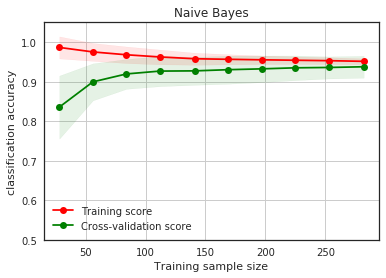

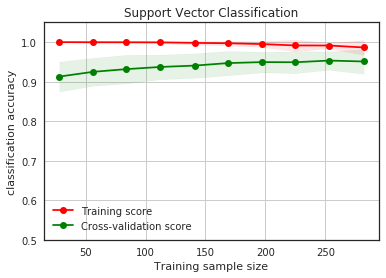

In [8]:
cv = ShuffleSplit(n_splits=80, test_size=0.2, random_state=100)
sns.set_style("white")

estimator = GaussianNB()
plot_learning_curve(estimator,"Naive Bayes",X,Y,ylim=[0.5,1.05],cv=cv)

estimator = LinearSVC()
plot_learning_curve(estimator,"Support Vector Classification",
                    X,Y,ylim=[0.5,1.05],cv=cv)


## Look at the data: correlation structure between items/questionnaires

In [9]:
def correlation_plot(cor,labels,colrange,gridcolor='grey',
                     title=None,figsize=(8,6)):
    sns.set_style("whitegrid")
    mpl.rcParams['grid.color'] = gridcolor
    unique_labels = np.unique(labels)
    labels_num = [np.where(unique_labels==x)[0].tolist()[0] \
                  for idx,x in enumerate(labels)]
    major_ticks = [np.min(np.where(np.array(labels_num)==x))-0.5 \
                   for x in range(len(unique_labels))]
    major_ticks.append(len(labels)-0.54)
    minor_ticks = [np.mean(np.where(np.array(labels_num)==x)) \
                   for x in range(len(unique_labels))]
    fig = plt.figure(figsize=figsize, dpi= 100, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax1 = ax.imshow(cor,cmap = "PuOr_r",vmin=colrange[0],vmax=colrange[1],
                    aspect='auto',interpolation='nearest')
    if title:
        ax.set_title(title)
    ax.set_xticks(major_ticks,minor=False)
    ax.set_xticks(minor_ticks,minor=True)
    ax.set_xticklabels(unique_labels,minor=True,rotation=90)
    ax.set_xticklabels(unique_labels,minor=False,visible=False)
    ax.set_yticks(major_ticks,minor=False)
    ax.set_yticks(minor_ticks,minor=True)
    ax.set_yticklabels(unique_labels,minor=True)
    ax.set_yticklabels(unique_labels,minor=False,visible=False)
    plt.colorbar(ax1)
    plt.tight_layout()

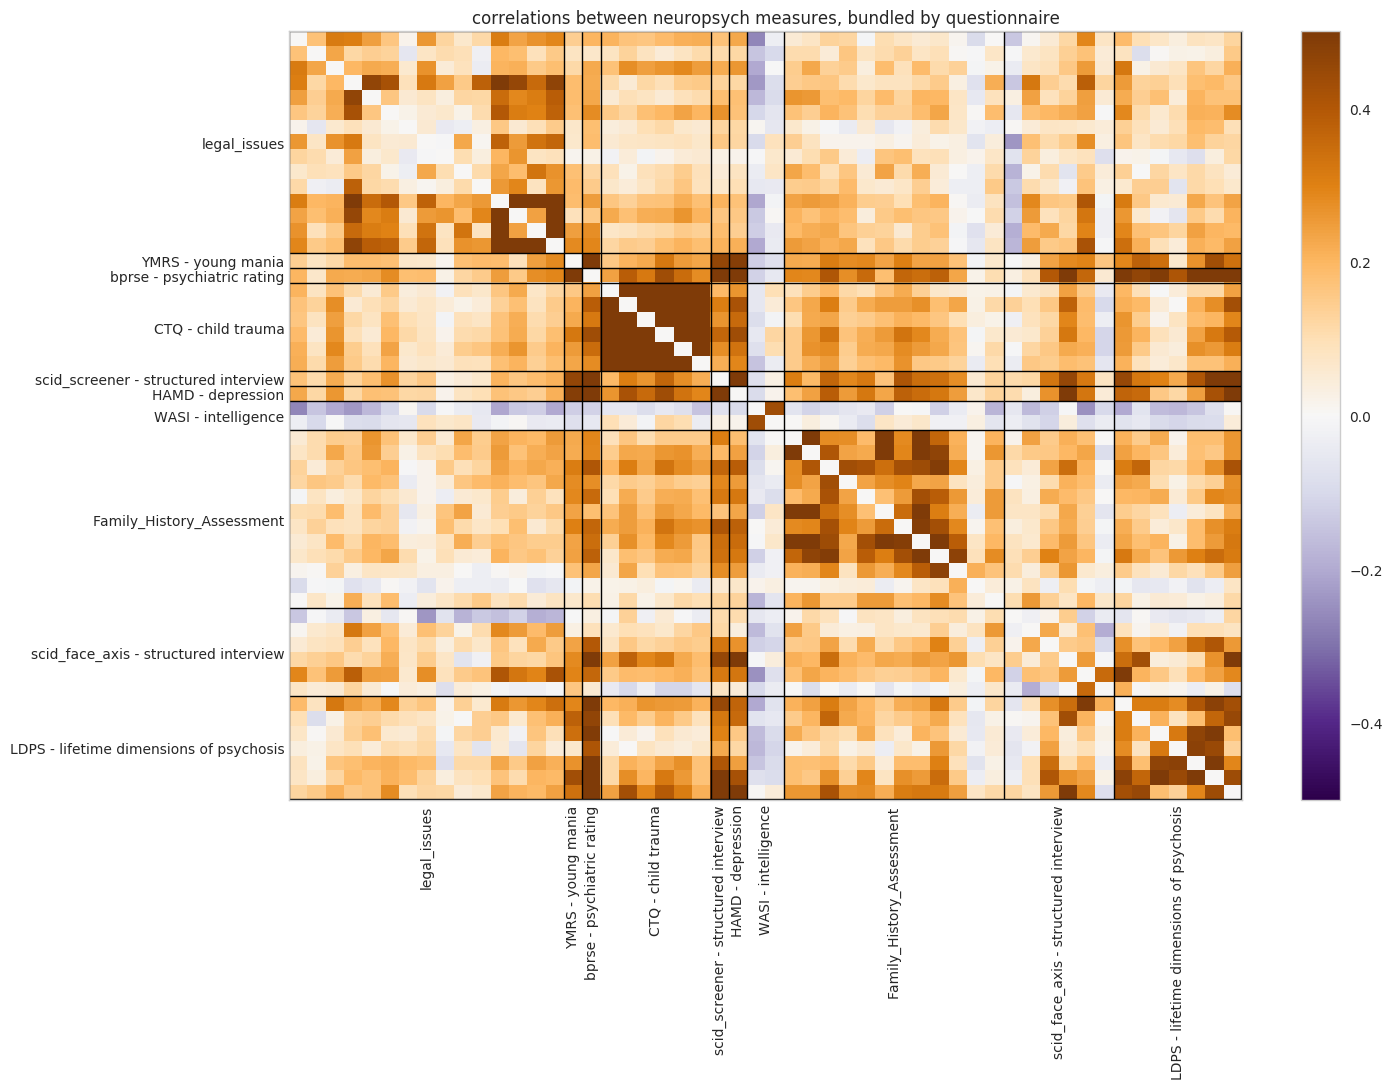

In [10]:
cor = np.array(RC_clean[all_vars].corr())
np.fill_diagonal(cor,0)
correlation_plot(cor = cor,labels = all_labels,colrange = [-0.5,0.5],
                 gridcolor='black',figsize=(15,11),
                 title='correlations between neuropsych measures, bundled by questionnaire'
                )

## Factor analysis: how many components?

I will test the number of components both in python and in R.  In python it's easy to measure the performance with cross-validation (here leave-1 out).  In R there are libraries that measure different properties of the correlation matrix.

In [11]:
def factor_ncomponents(X,n_components,cvgroups=3):
    fa = FactorAnalysis()
    fa.svd_method='randomized'
    fa.iterated_power=2
    fa.random_state = 100

    fa_mean_scores = []
    fa_std_scores = []
    maxlog = []
    for n in lp(n_components):
        fa.n_components = n
        cvscore = cross_val_score(fa, X,cv=cvgroups)
        fa_mean_scores.append(np.mean(cvscore))
        fa_std_scores.append(np.std(cvscore))
        fa.fit(X)
        maxlog.append(fa.loglike_[-1])

    return fa_mean_scores, fa_std_scores, maxlog

The measures that are computed are the loglikelihood of the training data (thus the obtained maximum loglikelihood, which can be expected to keep going up with more factors) and the loglikelihood of the testing data given the model.

In [12]:
# this takes a while to do the leave-1-out CV !
n_components = np.arange(0,50)
fa_mean_scores, fa_std_scores, maxlog = factor_ncomponents(
    X,n_components,cvgroups=5)
# fa_mean_scores, fa_std_scores, maxlog = factor_ncomponents(
#     X,n_components,cvgroups=X.shape[0])

Widget Javascript not detected.  It may not be installed or enabled properly.


Now we'll test in R using the psych library.

/home/users/jdurnez/.local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The estimated weights for the factor scores are probably incorrect.  Try a different factor extraction method.

  warnings.warn(x, RRuntimeWarning)


Parallel analysis suggests that the number of factors =  8  and the number of components =  8 


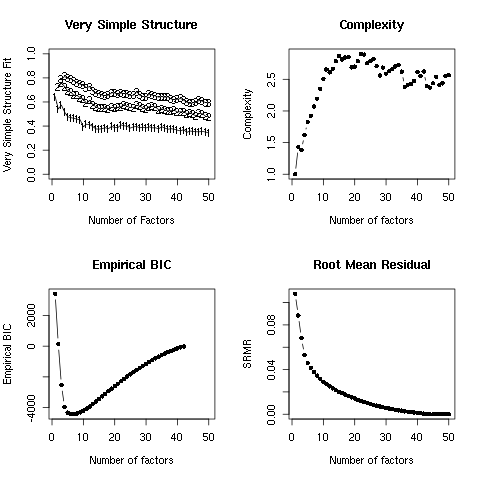

In [13]:
%%R -i X -o factortable

maxfac <- min(dim(X)[2],50)

library(psych)
factortable <- nfactors(X,n=maxfac,rotation='varimax')$vss.stats
factortable['eigen'] <- eigen(cor(X))$values[1:maxfac]

parallel <- fa.parallel(X,plot=FALSE)
factortable['parallel_data'] <- parallel$fa.values[1:maxfac]
factortable['parallel_sim'] <- parallel$fa.sim[1:maxfac]

vss <- vss(X,n=maxfac,rotate='varimax',plot=FALSE)
factortable['map'] <- vss$map

#### Number of components

Below we extract the results to evaluate the search for the optimal number of factors.
The figure shows that once again, the methods don't agree very much on the number of factors.  I would decide to go for 16: the median. **(#arbitrary)**

In [14]:
from utils import factanal
minfact = factanal.evaluate_factors(factortable)

Based on the likelihood ration test, Model(N)-Model(0), the minimum number of factors is 40
Based on the likelihood ration test, Model(b)-Model(n-1), the minimum number of factors is 42
Based on the RMSEA, the minimum number of factors is 16
Based on the kaiser criterion, the minimum number of factors is 14
Based on the BIC, the minimum number of factors is 16
Based on the empirical BIC, the minimum number of factors is 6
Based on the complexity, the minimum number of factors is 21
Based on the standardised root mean square residual, the minimum number of factors is 48
Based on parallel analysis, the minimum number of factors is 8
Based on the minimum average partial correlation method, the minimum number of factors is 5


utils/factanal.py:9: RuntimeWarning: invalid value encountered in less
  out["LRT_H0"]=sum(np.array(pvals)<0.05)


In [15]:
factortable['CV'] = fa_mean_scores
factortable['likelihood'] = maxlog
minfact['CV']=n_components[np.where(max(fa_mean_scores)==fa_mean_scores)[0][0]]
factortable['parallel']=factortable.parallel_data/factortable.parallel_sim
factortable.rename(columns={
        'map': 'MAP',
        'RMSEA':'RMSE',
        'complex':'complexity',
        'prob':'LRT_H0',
        'eigen':'kaiser'}, inplace=True)

factortable_norm = (factortable - factortable.mean()) / factortable.std()

In [16]:
print("median number of factors over methods: %i"%(np.median(minfact.values())))

median number of factors over methods: 14


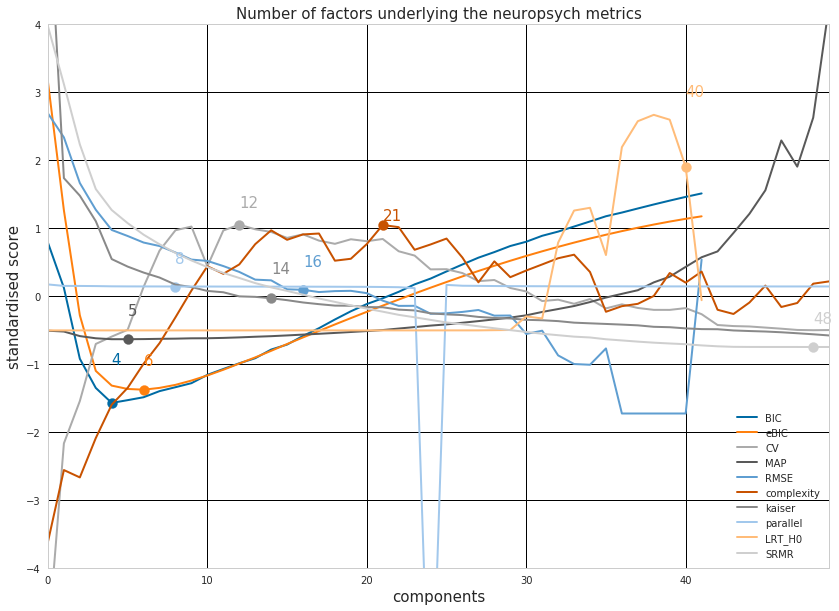

In [17]:
#sns.set_style("white")

tofigure = ['BIC','eBIC','CV','MAP','RMSE','complexity','kaiser','parallel','LRT_H0','SRMR']
fig = plt.figure(figsize=(14,10))

for idx,metric in enumerate(tofigure):
    plt.plot(n_components,factortable_norm[metric],label=metric,color=cols[idx],lw=2)
    plt.scatter(minfact[metric],factortable_norm[metric][minfact[metric]+1],s=100,color=cols[idx])
    ym = factortable_norm[metric][minfact[metric]]+0.35
    if not np.isnan(ym):
        plt.text(minfact[metric],ym,str(minfact[metric]),color=cols[idx],size=15)
plt.xlim([min(n_components),max(n_components)])
plt.ylim([-4,4])
plt.title('Number of factors underlying the neuropsych metrics',size=15)
plt.xlabel('components',size=15)
plt.ylabel('standardised score',size=15)
plt.legend()

In [18]:
pd.DataFrame(minfact,index=[""])

,BIC,CV,LRT_H0,LRT_Hn-1,MAP,RMSE,SRMR,complexity,eBIC,kaiser,parallel
,4,12,40,41,5,16,48,21,6,14,8


# Optimise number of factors for prediction accuracy

First I perform a factor analysis on the data for a range of factors.

In [19]:
%%R -i X -o pred

library(psych)
maxfac = 35

pred = array(NA,dim=c(353,maxfac,maxfac))
for (nfactors in 2:maxfac){
    fit <- fa(X,nfactors)
    loadings <- fit$loadings[1:dim(X)[2],1:nfactors]
    pred[,nfactors,1:nfactors] = X%*%loadings
    }

/home/users/jdurnez/.local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required namespace: GPArotation

  warnings.warn(x, RRuntimeWarning)
/home/users/jdurnez/.local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Failed with error:  
  warnings.warn(x, RRuntimeWarning)
/home/users/jdurnez/.local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
/home/users/jdurnez/.local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: ‘there is no package called ‘GPArotation’’
  warnings.warn(x, RRuntimeWarning)
/home/users/jdurnez/.local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/home/users/jdurnez/.local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/home/users/jdurnez/.local/lib/p

Now I look which number of factors has the best predictive power.

In [20]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
maxfac = 35
todo = {
    # just default settings
    "LinearSVM":LinearSVC(),
    "LogReg":LogisticRegression(),
    "RidgeClass":RidgeClassifier(), # for correlated metrics
    'DiscrAnalysis':LinearDiscriminantAnalysis()
}

numfacs=range(2,maxfac-1)
numcv = 20

out = {k:[] for k in todo.keys()}
for nfactors in lp(numfacs):
    data = pred[:,nfactors,:nfactors]
    for algor in todo.keys():
        cvscores = cross_val_score(todo[algor],data,y=Y,cv=numcv)
        out[algor].append(np.mean(cvscores))

Widget Javascript not detected.  It may not be installed or enabled properly.


In [21]:
def evaluate_algorithms_facta(out):
    plt.figure(figsize=(10,4))
    sns.set_style('white')
    for i,algor in enumerate(out.keys()):
        
        plt.plot(numfacs,out[algor],color=cols[i],label=algor)

    plt.xlabel("number of components")
    plt.ylabel("Prediction accuracy")
    plt.legend(loc='lower center')
    plt.title("Prediction accuracy as a function of the \n \
    number of components with %i-fold CV"%numcv)
    plt.ylim([0.8,1])

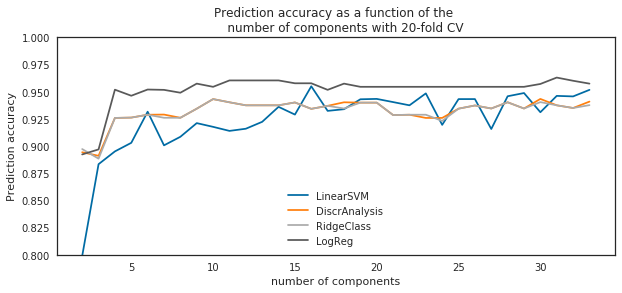

In [22]:
evaluate_algorithms_facta(out)

### Number of components according to prediction accuracy.

It's again pretty shaky as result, but it's interesting to see how both discriminant analysis and ridge classification starts losing it's predictive power at >10 factors.

In [23]:
numcomp = {k:np.arange(2,55)[np.where(np.max(v)==v)[0][0]] 
 for k,v in out.iteritems()}

pd.DataFrame(numcomp,index=[""])

,DiscrAnalysis,LinearSVM,LogReg,RidgeClass
,30,16,31,10


In [24]:
print("previous results based on correlation matrix metrics (only X)")
pd.DataFrame(minfact,index=[""])

previous results based on correlation matrix metrics (only X)


,BIC,CV,LRT_H0,LRT_Hn-1,MAP,RMSE,SRMR,complexity,eBIC,kaiser,parallel
,4,12,40,41,5,16,48,21,6,14,8


# Factor analysis with 10 factors

We do the factor analysis in R.  In R, we have easy access to rotation methods, which make the factors much more interpretable.

In [25]:
%%R -i X -o loadings

nfactors <- 10
library(psych)
fit <- fa(X,nfactors,rotate='varimax')
loadings <- fit$loadings[1:52,1:nfactors]

The scales that are assessedlegal_issues
YMRS - young mania
bprse - psychiatric rating
CTQ - child trauma
scid_screener - structured interview
HAMD - depression
WASI - intelligence
Family_History_Assessment
scid_face_axis - structured interview
LDPS - lifetime dimensions of psychosis


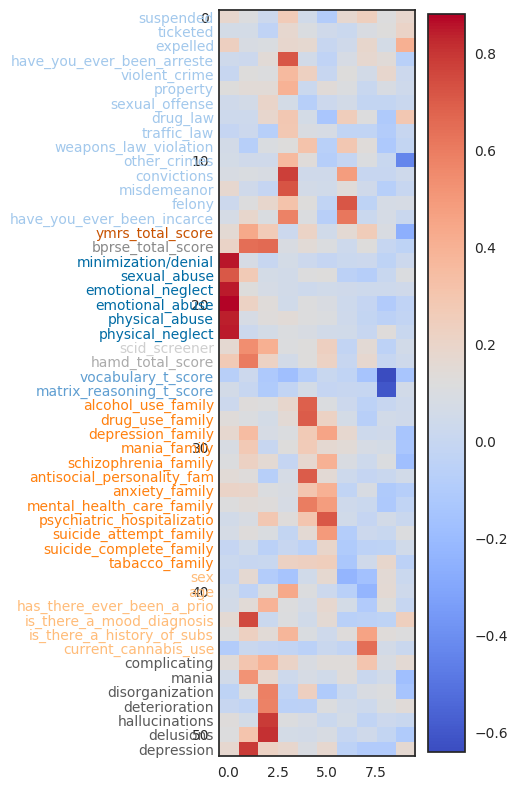

In [26]:
# this code makes nice figures of factors and their loadings
minor_ticks = np.arange(len(all_labels))

fig = plt.figure(figsize=(5, 8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax1 = ax.imshow(loadings,
                aspect='auto',interpolation='nearest',cmap='coolwarm')
ax.set_yticks(np.arange(X.shape[1]),minor=True)
ax.set_yticklabels(all_vars,minor=True)
plt.colorbar(ax1)

coldict = {k:cols[idx] for idx,k in enumerate(np.unique(all_labels))}
colors = [coldict[x] for x in all_labels]
for ytick, color in zip(ax.get_yticklabels(minor=True), colors):
    ytick.set_color(color)

plt.tight_layout()
print("The scales that are assessed"+"\n".join(subsets.keys()))

This looks pretty cool !
- factor 1: childhood trauma
- factor 2: psychosis
- factor 3: legal issues
- factor 4: family mental health
- factor 5: mood and depression
- factor 6: family psychosis
- factor 7: IQ (neg)
- factor 8: family psychiatry
- factor 9: smoking + substance abuse
- factor 10: ?

## Transform original data with factor solution

In [27]:
factor_descr = ['childhood_trauma','psychosis','legal','family_mental_health','mood_depression','family_psychosis',
                'IQ_(-)','family_psychiatry','substance','?']

Checking if we're doing the right computation :)

In [28]:
print("dimensions of X: %s"%str(X.shape))
print("dimensions of loadings: %s"%str(loadings.shape))
preds = X.dot(loadings)
print("dimensions of predictions: %s"%str(preds.shape))

dimensions of X: (353, 52)
dimensions of loadings: (52, 10)
dimensions of predictions: (353, 10)


In [29]:
y = pd.DataFrame(preds)
y = (y-y.mean())/y.std()
newcols = {k:"factor_%i_(%s)"%(k,factor_descr[k]) for k in range(10)}
y.rename(columns=newcols, inplace=True)
y['patient']=['patient' if x==1 else 'HC' for x in Y]
y['UID']=RC_clean.UID
data = pd.melt(y,id_vars=['patient'],value_vars=newcols.values())

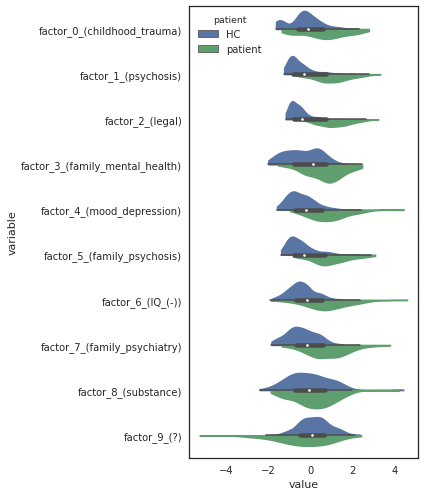

In [30]:
plt.figure(figsize=(6,7))
sns.violinplot(x='value',y='variable',data=data,hue='patient',split=True,orient='h',cut=0,inner='box',linewidth=1.5)
plt.tight_layout()

## Inspect loss in predictive ability with ML

Naive Bayes seems to be suffering from larger bias.  SVM still results in a very high accuracy (albeit less).

**NOTE:**  in the original scale, there were a few scales that were not filled out with the healthy controls (need to check this) so to apply machine learning there was an easy one.  Here it's certainly about underlying factors...

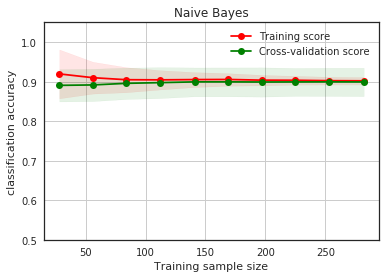

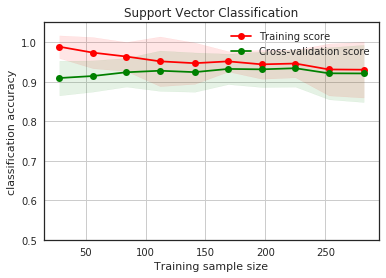

In [31]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=80, test_size=0.2, random_state=100)
sns.set_style("white")

estimator = GaussianNB()
plot_learning_curve(estimator,"Naive Bayes",preds,Y,ylim=[0.5,1.05],cv=cv)

estimator = LinearSVC()
plot_learning_curve(estimator,"Support Vector Classification",preds,Y,ylim=[0.5,1.05],cv=cv)


## Write away factor solution

In [32]:
y.to_csv(os.path.join(os.environ.get("TABLEDIR"),"neuropsych_factor.csv"))

In [33]:
# from sklearn.cross_decomposition import CCA
# cca = CCA(n_components = 4)
# cca.fit(X_new,Y)
# cca.get_params()
# #cca.x_scores_.shape
# cca.x_weights_.shape
# cca.y_weights_